<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

<h1><center>Assignment 01 (Part 02)</center></h1>
<h2>
Ayushman Anupam (MDS202411)
</h2>

</div>

In [1]:
# importing needed libraries

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, auc

In [2]:
folder_path = "data"

train_df_path = os.path.join(folder_path, "train_df.csv")
validation_df_path = os.path.join(folder_path, "validation_df.csv")
test_df_path = os.path.join(folder_path, "test_df.csv")

train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)
val_df = pd.read_csv(validation_df_path)

### **Creating needed helper function**

In [3]:
# function to get evaluation score
def evaluate_predictions(y_true, y_pred):
    print("Accuracy: ", round(accuracy_score(y_true, y_pred), 5))
    print("Precision:", round(precision_score(y_true, y_pred), 5))
    print("Recall:   ", round(recall_score(y_true, y_pred), 5))
    print("F1:       ", round(f1_score(y_true, y_pred), 5))

    p, r, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    print("PR AUC:   ", round(auc(r, p), 5))

# function to plot confusion martix and PR curve in 1x2 grid
def plot_pr_curve_and_confusion_matrix(y_true, y_pred, y_scores):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Precision-Recall Curve
    p, r, _ = precision_recall_curve(y_true, y_scores, pos_label=1)
    axes[0].plot(r, p, label='Precision-Recall Curve')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve')
    axes[0].legend()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=['ham', 'spam'],
        yticklabels=['ham', 'spam'],
        ax=axes[1]
    )
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()

# function to plot confusion matrix for all model in 1x3 grid
def plot_confusion_matrices(models, model_names, X, y):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    if n_models == 1:
        axes = [axes] 

    for i, model in enumerate(models):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred)

        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'],
            ax=axes[i]
        )

        axes[i].set_title(model_names[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# function to plot P-R curve for all model in 1x3 grid
def plot_pr_auc_curves(models, model_names, X, y):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    if n_models == 1:
        axes = [axes]

    for i, model in enumerate(models):
        y_scores = model.predict_proba(X)[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_scores)
        pr_auc = auc(recall, precision)

        axes[i].plot(recall, precision, label=f'PR AUC = {pr_auc:.5f}')
        axes[i].set_title(model_names[i])
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# function to evaluation all 3 models
def benchmark_models(models, model_names, X_test, y_test):
    df = pd.DataFrame(
        np.zeros((len(models), 5)),
        index=model_names,
        columns=["Accuracy", "Precision", "Recall", "F1-score", "PR-AUC"]
    )

    for i, model in enumerate(models):
        y_pred = model.predict(X_test)
        y_scores = model.predict_proba(X_test)[:, 1]

        df.iloc[i, 0] = accuracy_score(y_test, y_pred)
        df.iloc[i, 1] = precision_score(y_test, y_pred)
        df.iloc[i, 2] = recall_score(y_test, y_pred)
        df.iloc[i, 3] = f1_score(y_test, y_pred)
        p, r, _ = precision_recall_curve(y_test, y_scores)
        df.iloc[i, 4] = auc(r, p)

    return df.round(5)

# function to plot histogram of all evaluation matrices for all model in 1x3 and 1x2 grid
def plot_benchmark_histograms(benchmark_df):
    colors = {
        "Naive Bayes": "tab:blue",
        "Logistic Regression": "tab:orange",
        "Random Forest": "tab:green"
    }

    models = benchmark_df.index

    # 1x3 grid: Accuracy, Precision, Recall
    metrics_1 = ["Accuracy", "Precision", "Recall"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, metric in enumerate(metrics_1):
        for model in models:
            axes[i].bar(
                model,
                benchmark_df.loc[model, metric],
                color=colors[model]
            )
        axes[i].set_title(metric)
        axes[i].set_ylim(0.9, 1.015)
        axes[i].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

    # 1x2 grid: F1-score, PR-AUC
    metrics_2 = ["F1-score", "PR-AUC"]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    for i, metric in enumerate(metrics_2):
        for model in models:
            axes[i].bar(
                model,
                benchmark_df.loc[model, metric],
                color=colors[model]
            )
        axes[i].set_title(metric)
        axes[i].set_ylim(0.9, 1.015)
        axes[i].set_ylabel("Score")

    plt.tight_layout()
    plt.show()


## Model Selection

In this project, I used 3 machine learning models for spam/ham classification and each of model is evaluated using standard metrices like Accuracy, Precision, Recall, F1-score and Area under the Precision-Recall respectively.

1. Naive Bayes
2. Logistic Regression
3. Random Forest Classifier

## **1. Naive Bayes Classifier**

In [4]:
# Hyper-parameters of Naive Bayes
print(MultinomialNB().get_params()) # Multinomial Naive Bayes

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [5]:
nb_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

nb_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

### **Performance on training data**

Accuracy:  0.98077
Precision: 1.0
Recall:    0.8566
F1:        0.92276
PR AUC:    0.93791


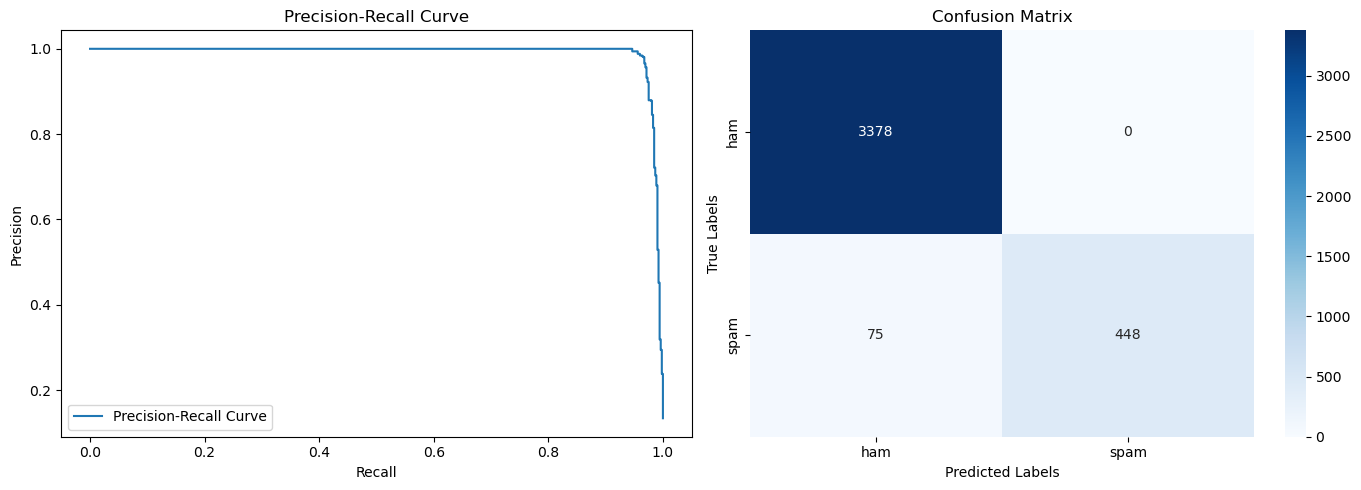

In [6]:
nb_prediction = nb_model.predict(train_df['message'])
nb_scores = nb_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    nb_prediction,
    nb_scores
)


### **Performance on validation data**

Accuracy:  0.96592
Precision: 1.0
Recall:    0.74497
F1:        0.85385
PR AUC:    0.88952


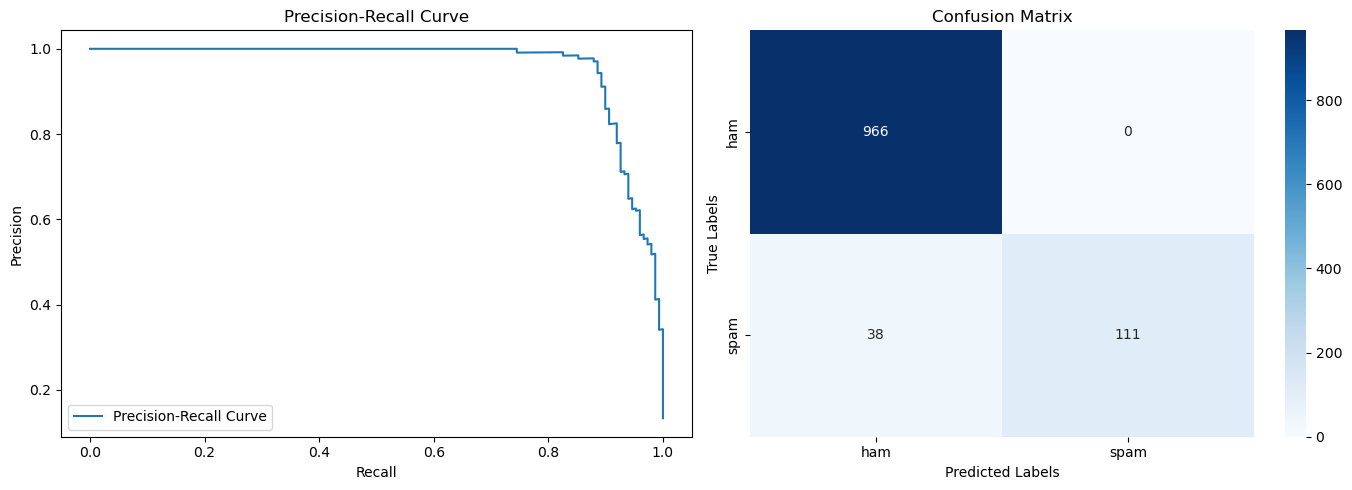

In [7]:
nb_prediction = nb_model.predict(val_df['message'])
nb_scores = nb_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    nb_prediction,
    nb_scores
)


### **Hyperparameter tuning of NaiveBayes**

In [8]:
param_grid = {
    'classifier__alpha': [0.05, 0.1, 0.5, 1],
    'classifier__fit_prior': [True, False],
}

NB_model = GridSearchCV(nb_model, 
                        param_grid, 
                        cv=5, 
                        scoring='f1', 
                        verbose=1, 
                        n_jobs=-1)
NB_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.05, 0.1, 0.5, 1],
                         'classifier__fit_prior': [True, False]},
             scoring='f1', verbose=1)

In [9]:
print("Best parameters:", NB_model.best_params_)
print("Best f1 score:", NB_model.best_score_)

Best parameters: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
Best f1 score: 0.9393387544048206


### **Performance on training data**

Accuracy:  0.99795
Precision: 1.0
Recall:    0.9847
F1:        0.99229
PR AUC:    0.99338


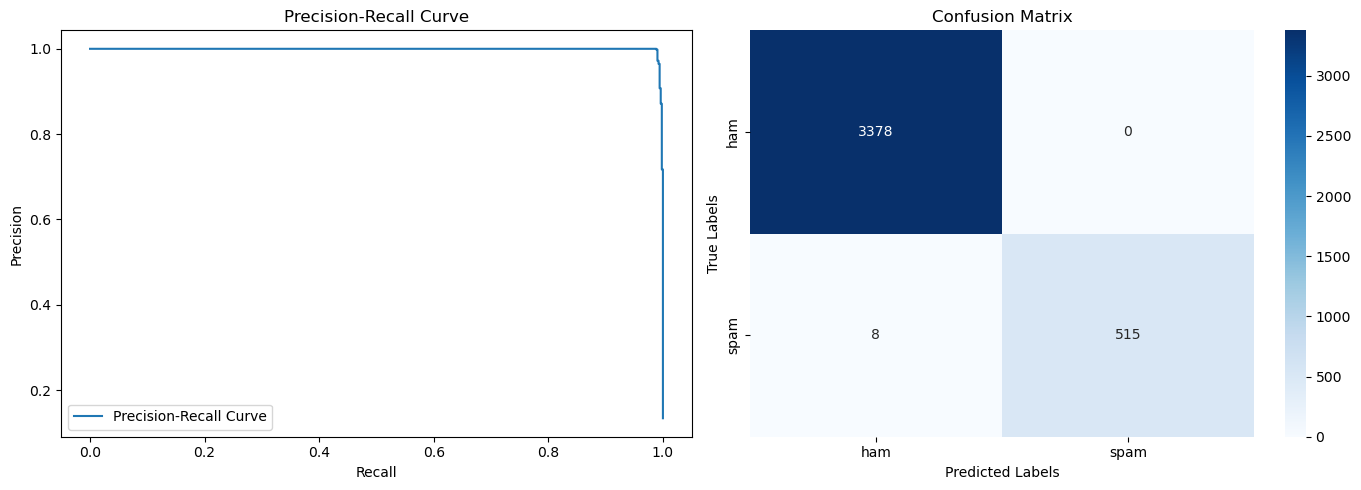

In [10]:
nb_prediction = NB_model.predict(train_df['message'])
nb_scores = NB_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    nb_prediction,
    nb_scores
)


### **Performance on Validation data**

Accuracy:  0.98117
Precision: 0.98485
Recall:    0.87248
F1:        0.92527
PR AUC:    0.93719


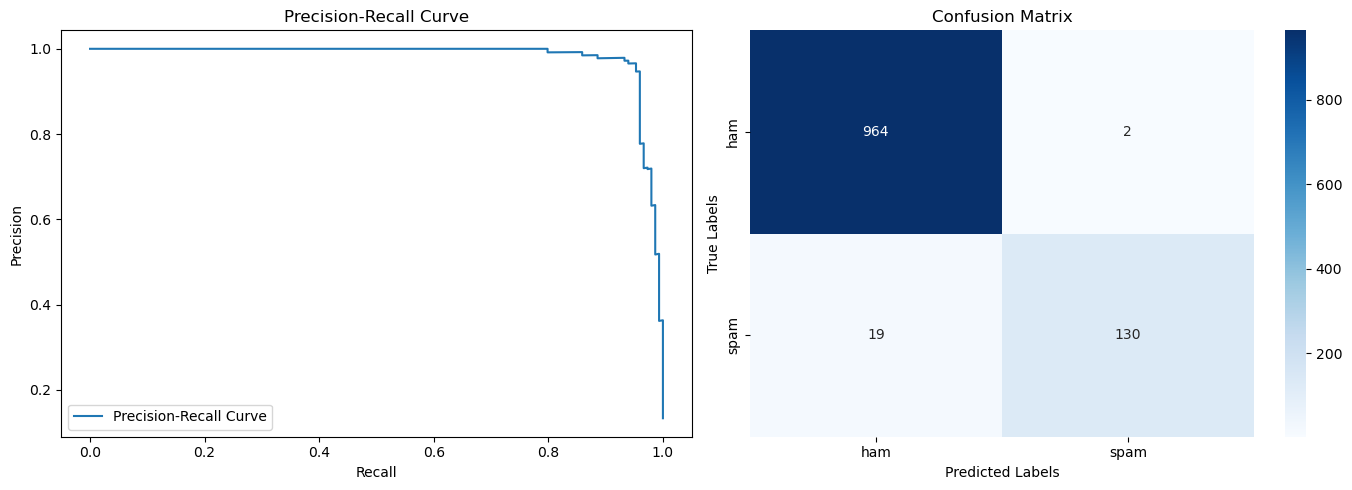

In [11]:
nb_prediction = NB_model.predict(val_df['message'])
nb_scores = NB_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    nb_prediction,
    nb_scores
)


## **2. Logistic Regresion Classifier**

In [12]:
# Hyperparameters of logistice regression
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [13]:
# defining model
lr_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=42, max_iter=500))  # train on TF-IDF vectors w/ logistic regression
])

# training model on train set
lr_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 LogisticRegression(max_iter=500, random_state=42))])

### **Performance on training data**

Accuracy:  0.96873
Precision: 0.98783
Recall:    0.77629
F1:        0.86938
PR AUC:    0.89706


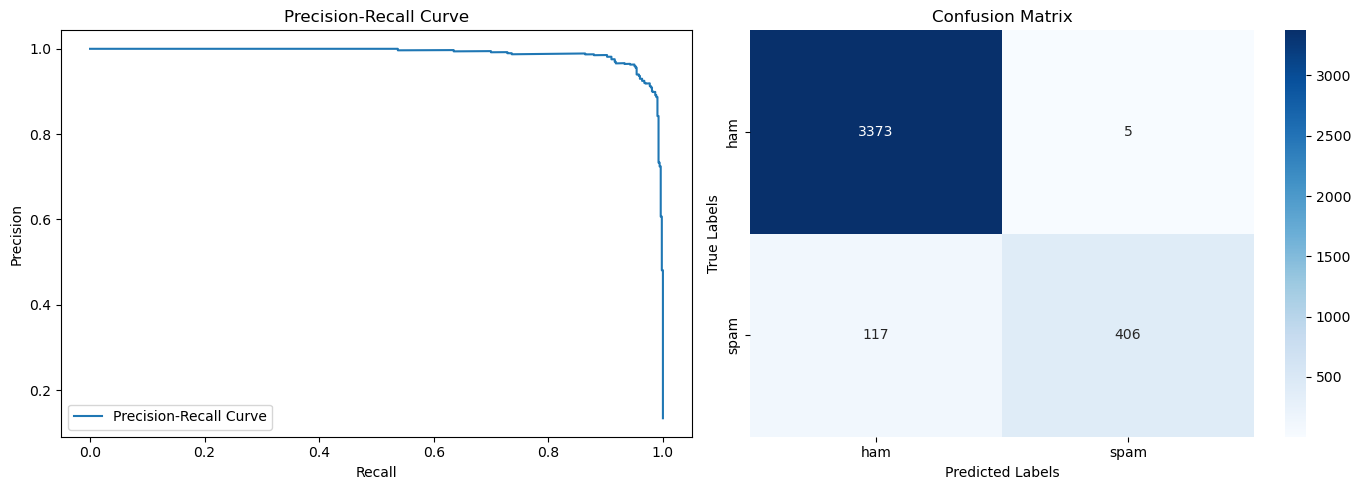

In [14]:
lr_prediction = lr_model.predict(train_df['message'])
lr_scores = lr_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    lr_prediction,
    lr_scores
)


### **Performance on Validation data**

Accuracy:  0.96682
Precision: 0.98276
Recall:    0.7651
F1:        0.86038
PR AUC:    0.88962


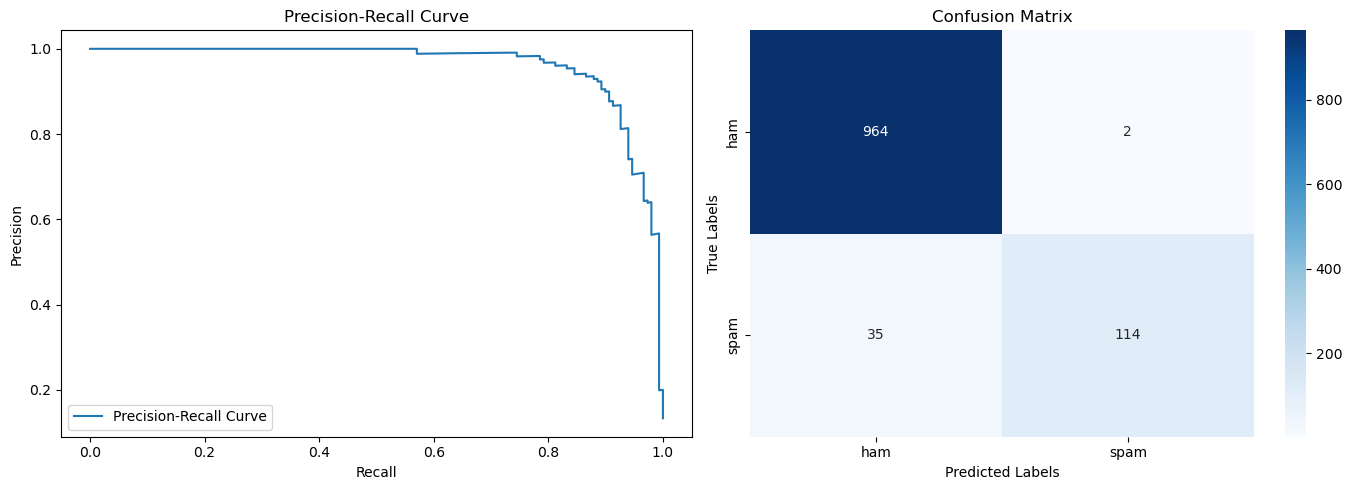

In [15]:
lr_prediction = lr_model.predict(val_df['message'])
lr_scores = lr_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    lr_prediction,
    lr_scores
)


## **Hyperparameter Tuning**

In [16]:
param_grid = {
    'classifier__C': [1, 5, 10, 25, 50],
    'classifier__class_weight': [None, 'balanced']
}

LR_model = GridSearchCV(
    lr_model,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

LR_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 5, 10, 25, 50],
                         'classifier__class_weight': [None, 'balanced']},
             scoring='f1', verbose=1)

In [17]:
print("Best parameters:", LR_model.best_params_)
print("Best CV F1 score:", LR_model.best_score_)

Best parameters: {'classifier__C': 50, 'classifier__class_weight': 'balanced'}
Best CV F1 score: 0.9442207497933902


### **Performance on training data**

Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
PR AUC:    1.0


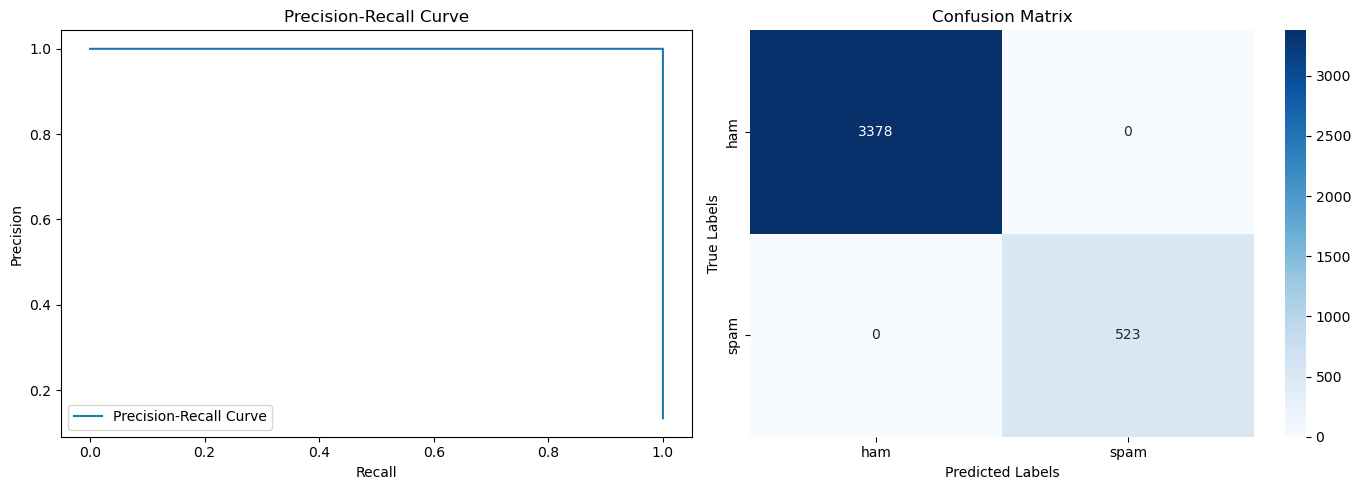

In [18]:
lr_prediction = LR_model.predict(train_df['message'])
lr_scores = LR_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    lr_prediction,
    lr_scores
)


### **Performance on Validation data**

Accuracy:  0.98027
Precision: 0.93793
Recall:    0.91275
F1:        0.92517
PR AUC:    0.93117


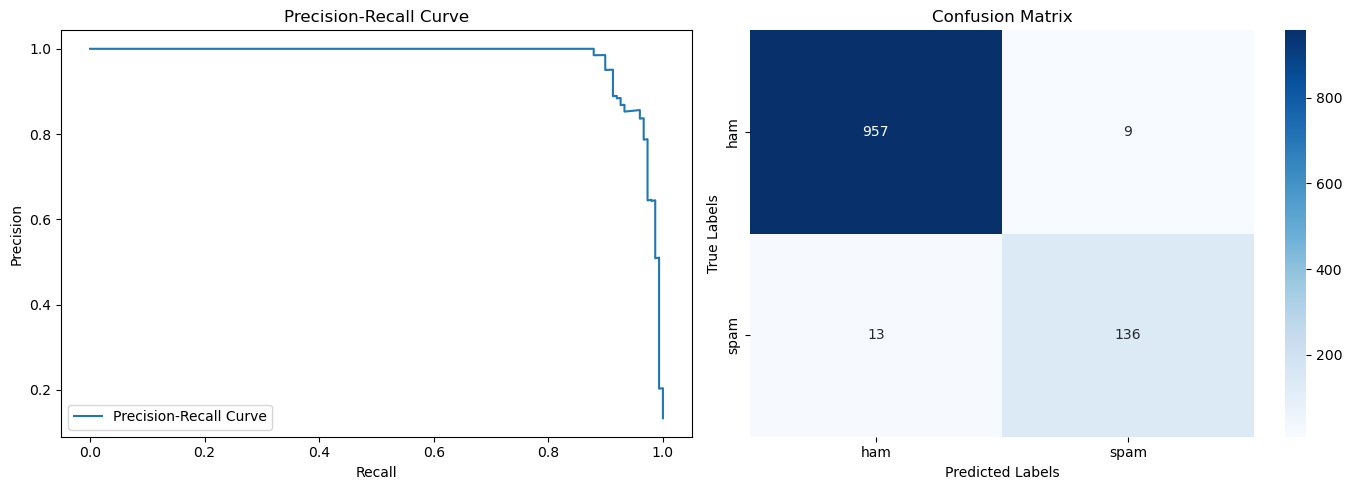

In [19]:
lr_prediction = LR_model.predict(val_df['message'])
lr_scores = LR_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    lr_prediction,
    lr_scores
)


## **3. Random Forest Classifier**

In [20]:
# Hyperparameters of RandomForest
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
# defining model
rf_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier( # train on TF-IDF vectors w/ SVM classifier
        n_estimators=400,
        random_state=42,
        n_jobs=-1))  
])

# training model on train set
rf_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

### **Performance on training data**

Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
PR AUC:    1.0


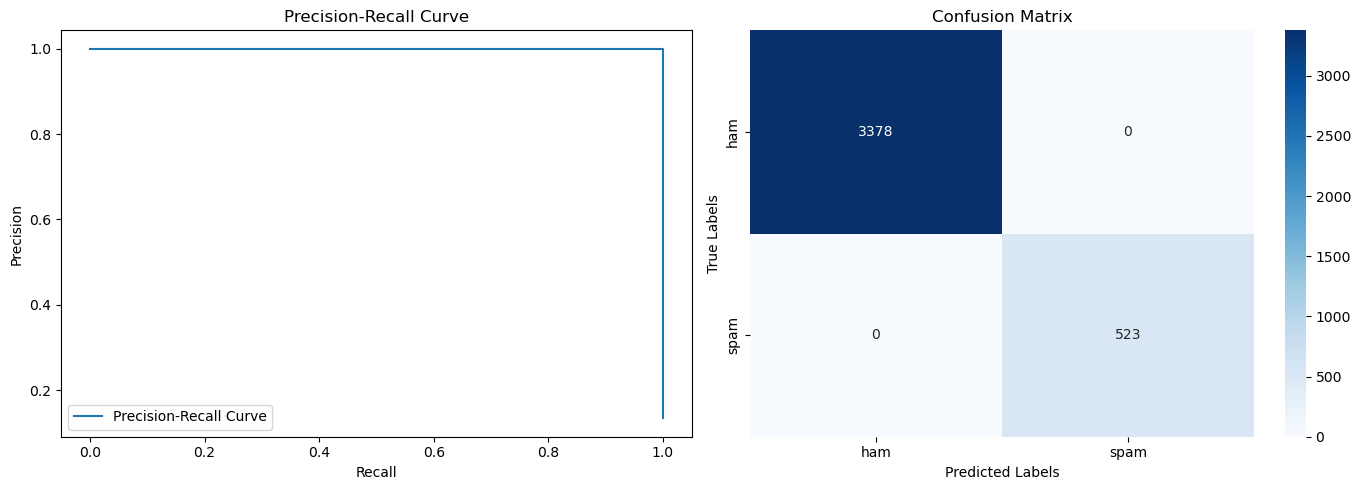

In [22]:
rf_prediction = rf_model.predict(train_df['message'])
rf_scores = rf_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    rf_prediction,
    rf_scores
)

### **Performance on Validation data**

Accuracy:  0.97848
Precision: 1.0
Recall:    0.83893
F1:        0.91241
PR AUC:    0.93023


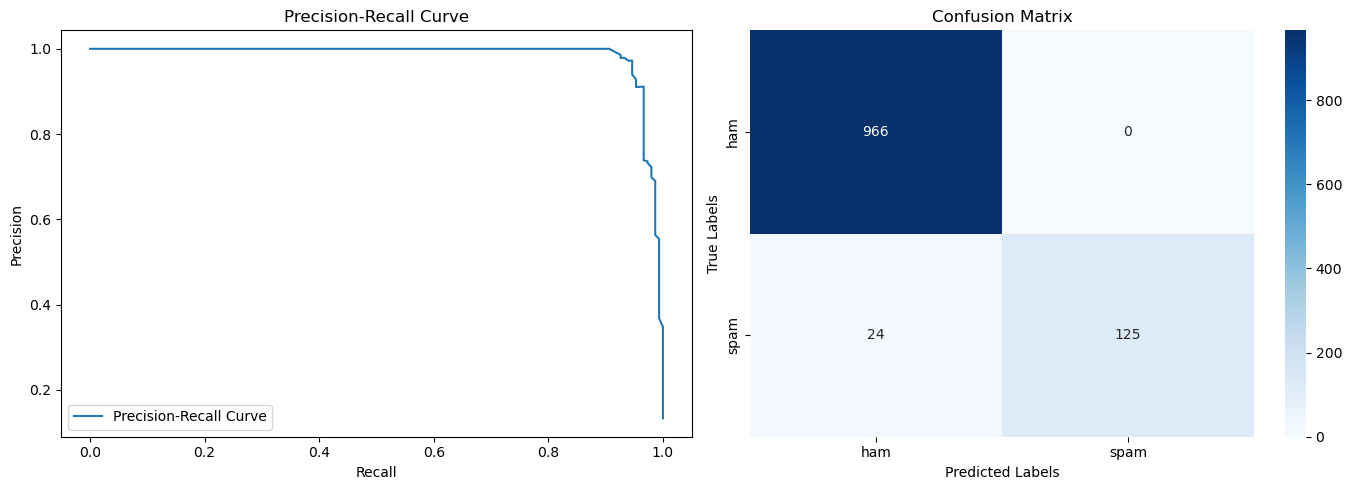

In [23]:
rf_prediction = rf_model.predict(val_df['message'])
rf_scores = rf_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    rf_prediction,
    rf_scores
)

In [24]:
param_grid = {
    # 'classifier__n_estimators': [200, 400],
    # 'classifier__max_depth': [None, 40, 60],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': [None, 'balanced']
}

RF_model = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

RF_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        RandomForestClassifier(n_estimators=400,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__min_samples_split': [2, 5]},
             scoring='f1', verbose=1)

In [25]:
print("Best parameters:", RF_model.best_params_)
print("Best CV F1 score:", RF_model.best_score_)

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__min_samples_split': 5}
Best CV F1 score: 0.9317632381166842


### **Performance on training data**

Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
PR AUC:    1.0


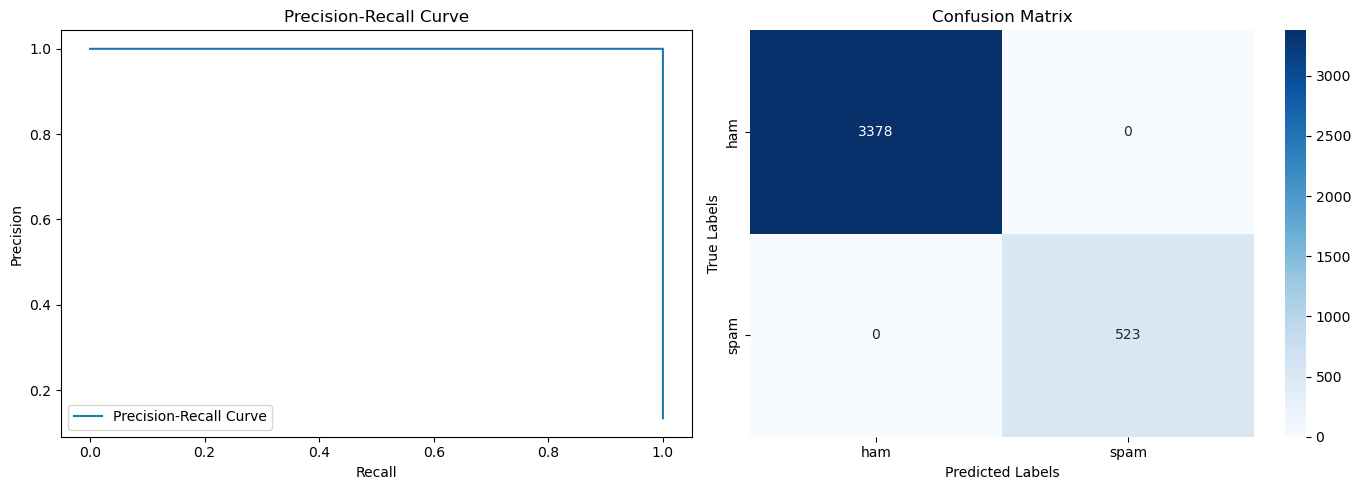

In [26]:
rf_prediction = RF_model.predict(train_df['message'])
rf_scores = RF_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    rf_prediction,
    rf_scores
)


### **Performance on Validation data**

Accuracy:  0.98296
Precision: 1.0
Recall:    0.87248
F1:        0.9319
PR AUC:    0.94476


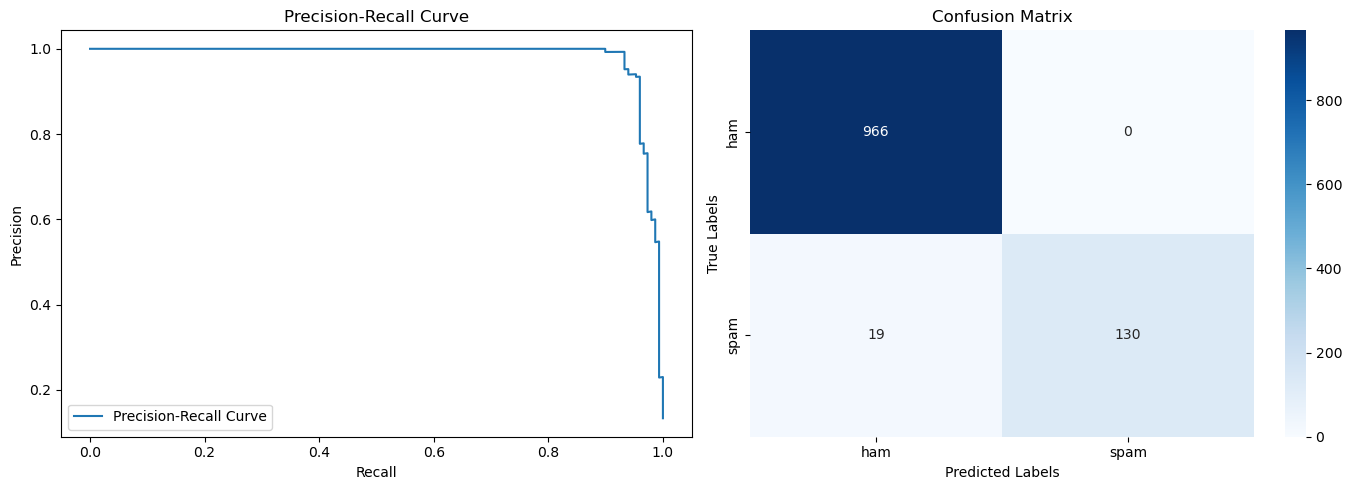

In [27]:
rf_prediction = RF_model.predict(val_df['message'])
rf_scores = RF_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    rf_prediction,
    rf_scores
)


# Testing all three models on the Test Data

In [28]:
models = [ NB_model.best_estimator_, LR_model.best_estimator_, RF_model.best_estimator_]
model_names = [ "Naive Bayes", "Logistic Regression", "Random Forest"]

benchmark_df = benchmark_models(
    models=models,
    model_names=model_names,
    X_test=test_df['message'],
    y_test=test_df['label']
)
benchmark_df


,Accuracy,Precision,Recall,F1-score,PR-AUC
Naive Bayes,0.99283,1.0000,0.94667,0.97260,0.97950
Logistic Regression,0.99283,0.9863,0.96000,0.97297,0.98011
Random Forest,0.98925,1.0000,0.92000,0.95833,0.98023


### **Confusion matrix and PR-AUC curve for all 3 models**

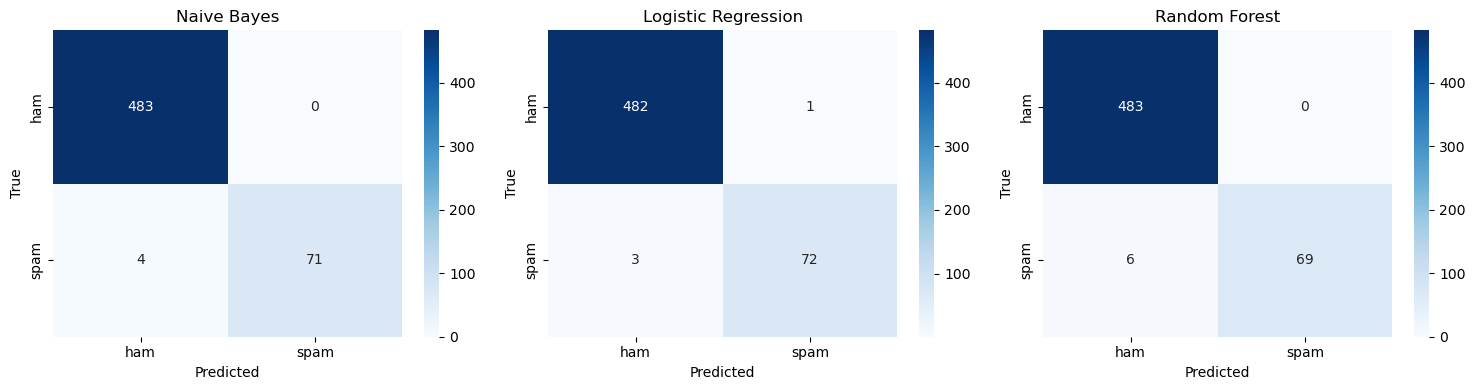

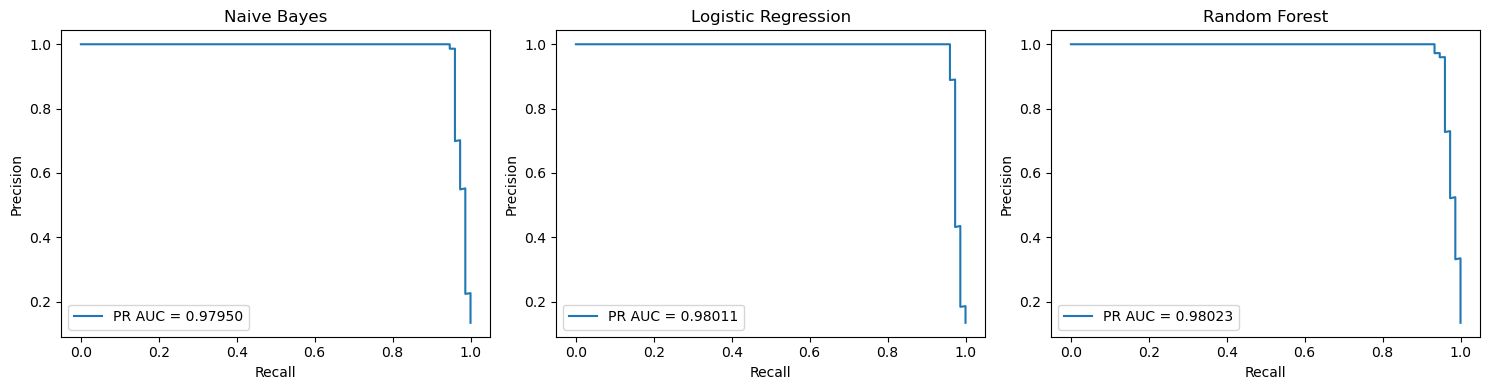

In [29]:
plot_confusion_matrices(
    models=models,
    model_names=model_names,
    X=test_df['message'],
    y=test_df['label']
)

plot_pr_auc_curves(
    models=models,
    model_names=model_names,
    X=test_df['message'],
    y=test_df['label']
)

### **Evaluation matices for all 3 models**

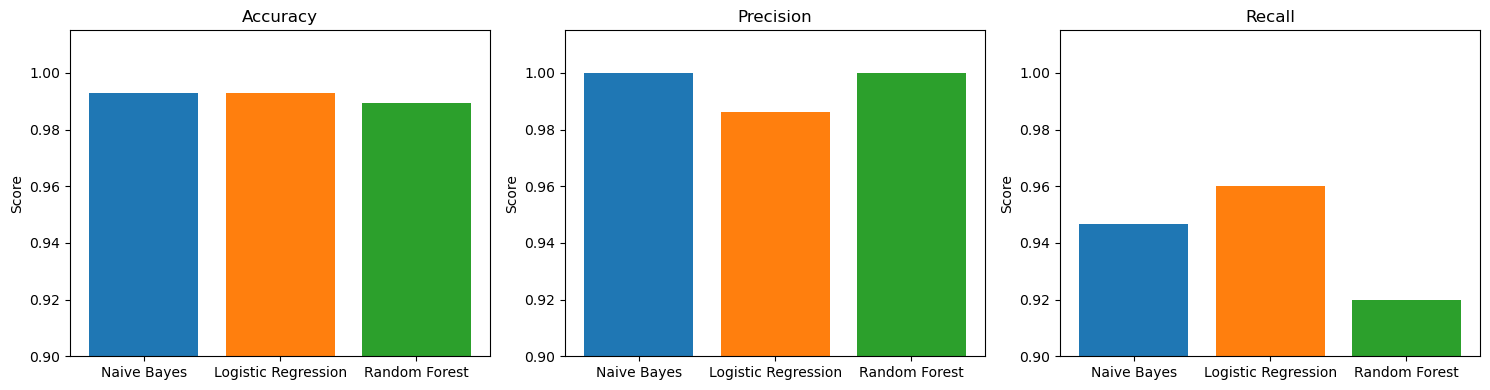

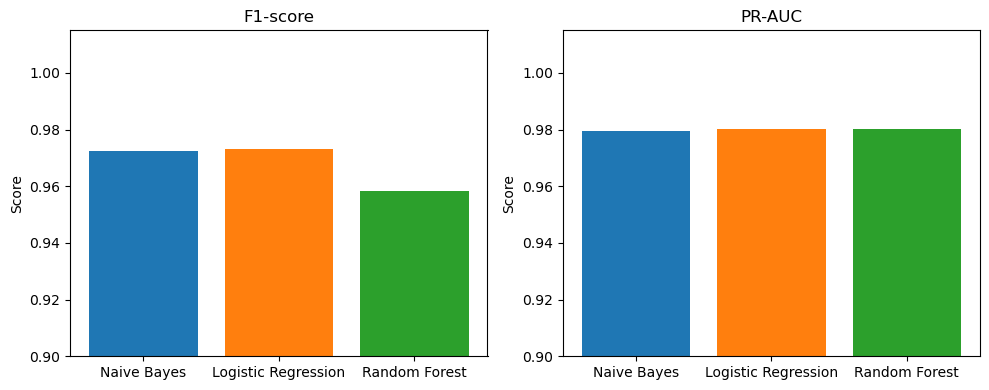

In [30]:
plot_benchmark_histograms(benchmark_df)

### **Sample Prediction**

In [31]:
sample_df = test_df.sample(n=10)

nb_preds = NB_model.best_estimator_.predict(sample_df['message'])
lr_preds = LR_model.best_estimator_.predict(sample_df['message'])
rf_preds = RF_model.best_estimator_.predict(sample_df['message'])

comparison_df = pd.DataFrame({
    "Index": sample_df.index,
    "Original Label": sample_df['label'].values,
    "Naive Bayes": nb_preds,
    "Logistic Regression": lr_preds,
    "Random Forest": rf_preds
})
label_map = {0: "ham", 1: "spam"}
result_df = comparison_df.replace(label_map)

def highlight_mismatches(row):
    styles = [''] * len(row)
    true_label = row["Original Label"]

    for i, col in enumerate(row.index):
        if col in ["Naive Bayes", "Logistic Regression", "Random Forest"]:
            if row[col] != true_label:
                styles[i] = 'color: red; font-weight: bold'
    return styles


styled_df = result_df.style.apply(highlight_mismatches, axis=1)
styled_df


,Index,Original Label,Naive Bayes,Logistic Regression,Random Forest
0,376,ham,ham,ham,ham
1,44,spam,spam,spam,spam
2,457,spam,spam,spam,spam
3,354,ham,ham,ham,ham
4,557,spam,spam,spam,spam
5,6,ham,ham,ham,ham
6,273,ham,ham,ham,ham
7,52,ham,ham,ham,ham
8,336,ham,ham,ham,ham
9,470,ham,ham,ham,ham


## **Result Discussion**

### `Model 01: Naive Bayes (Multinomial NB)`

**What it captures well:**
Naive Bayes performs strongly because SMS spam contains distinctive keywords (e.g., “free”, “win”, “offer”) whose individual frequencies are highly informative. The model assumes feature independence, which works surprisingly well for bag-of-words representations. This is reflected in its high precision (1.0) and strong PR-AUC on the test set.

**What it fails to capture:**
Because it ignores word interactions and context, Naive Bayes cannot model subtle phrase-level patterns (e.g., negations or multi-word expressions). This limitation leads to slightly lower recall on spam compared to Logistic Regression.

**Overfitting considerations:**
Although training performance improves significantly after tuning, test performance remains stable, indicating limited overfitting. The simplicity of the model acts as a natural regularizer.



### `Model 02: Logistic Regression`

**What it captures well:**
Logistic Regression effectively models weighted combinations of words and learns discriminative boundaries in the high-dimensional TF-IDF space. It balances precision and recall better than Naive Bayes, achieving the highest F1-score and PR-AUC on the test set. This indicates strong generalization under class imbalance.

**What it fails to capture:**
Being a linear model, Logistic Regression cannot capture non-linear feature interactions. However, in sparse text data, such interactions are often unnecessary.

**Overfitting considerations:**
While training performance reaches 1.0 after tuning, test performance does not degrade, suggesting that regularization successfully controls overfitting. The small generalization gap indicates a robust model.



### `Model 03: Random Forest`

**What it captures well:**
Random Forest can capture non-linear patterns and complex interactions between features. This explains the perfect performance on training data, both with and without tuning.

**What it fails to capture:**
TF-IDF text features are high-dimensional and sparse, which is poorly suited to tree-based models. As a result, Random Forest struggles to generalize, showing lower recall and F1-score on the test set compared to linear models.

**Overfitting considerations:**
The perfect training scores combined with weaker test performance indicate clear overfitting. The model memorizes training data but does not generalize well to unseen messages.


<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

### **Best model based on results and Industrial use: `Naive Bayes`**

**Why? —**  
- Naive Bayes is more suitable for spam detection and real-world deployment due to its **perfect precision**, **low inference latency**, and **minimal risk of false positives**.  
- Although its F1-score is slightly lower than Logistic Regression, **precision is prioritized** because misclassifying legitimate (ham) messages as spam is more harmful than allowing some spam messages to pass through.  
- From an industry perspective, Naive Bayes provides **fast, scalable, and interpretable predictions**, making it well-suited for real-time message filtering systems.  
- Logistic Regression, while strong in overall metrics, exhibits lower precision, increasing the risk of false positives, whereas Random Forest shows signs of **overfitting** and does not generalize well on unseen data.

> A two-stage filtering strategy can further balance spam reduction with user trust and operational safety.

</div>